Data set paris

In [12]:
import pandas as pd
import requests
import os

WINNING_DATE = "2024-06-10"

PAS BESOIN DE RELANCER CETTE CELLULE

In [ ]:
import os
import requests
import pandas as pd

WINNING_DATE = "2024-06-10"
DATA_URL = f"http://data.insideairbnb.com/france/ile-de-france/paris/{WINNING_DATE}/data/listings.csv.gz"

# --- CORRECTION DU CHEMIN ---
# "../" signifie "remonter d'un dossier parent"
SAVE_PATH = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"

# --- CRÉATION DU DOSSIER (Sécurité) ---
# On récupère le chemin du dossier (../data) et on le crée s'il n'existe pas
folder_path = os.path.dirname(SAVE_PATH)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"📂 Dossier créé : {folder_path}")

print(f"--- TÉLÉCHARGEMENT DE LA VERSION GAGNANTE ({WINNING_DATE}) ---")

# 1. TÉLÉCHARGEMENT
if not os.path.exists(SAVE_PATH):
    print(f"Téléchargement depuis : {DATA_URL}")
    print(f"Vers : {SAVE_PATH}")
    try:
        response = requests.get(DATA_URL, stream=True)
        if response.status_code == 200:
            with open(SAVE_PATH, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024*1024):
                    f.write(chunk)
            print("✅ Téléchargement terminé !")
        else:
            print(f"❌ Erreur de téléchargement (Code {response.status_code}).")
    except Exception as e:
        print(f"❌ Erreur technique : {e}")
else:
    print(f"ℹ️ Le fichier existe déjà ici : {SAVE_PATH}")

# 2. CHARGEMENT ET NETTOYAGE PRÉLIMINAIRE
print("\n--- PRÉPARATION DU DATASET ---")
try:
    # On charge
    df = pd.read_csv(SAVE_PATH, compression='gzip')
    print(f"Taille brute : {len(df)} lignes")

    # On nettoie le prix
    # Conversion string -> float
    if df['price'].dtype == 'object':
        df['price_clean'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True)
        df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')
    else:
        df['price_clean'] = df['price'] # Déjà numérique

    # On supprime les lignes sans prix
    df_clean = df
    df_clean = df_clean.dropna(subset=['price_clean'])

    print(f"Taille après suppression des sans-prix : {len(df_clean)} lignes")
    perte = 100 - (len(df_clean)/len(df)*100)
    print(f"Perte de données : {perte:.1f}% (Acceptable)")

    # 3. VÉRIFICATION AMENITIES
    sample_amenity = str(df_clean['amenities'].iloc[0])
    print(f"\nExemple d'amenities : {sample_amenity[:50]}...")

    if "wifi" in sample_amenity.lower() or "[" in sample_amenity:
        print("✅ AMENITIES CONFIRMÉES : Prêt pour le Feature Engineering !")
        
        # Correction du chemin de sauvegarde pour le fichier nettoyé aussi
        clean_save_path = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"
        df_clean.to_csv(clean_save_path, index=False, compression='gzip')
        print(f"💾 Fichier de travail sauvegardé sous : '{clean_save_path}'")
    else:
        print("⚠️ ATTENTION : Les amenities semblent vides.")

except FileNotFoundError:
    print(f"❌ ERREUR CRITIQUE : Le fichier n'a pas été trouvé à l'emplacement {SAVE_PATH}")

--- TÉLÉCHARGEMENT DE LA VERSION GAGNANTE (2024-06-10) ---
ℹ️ Le fichier existe déjà ici : ../data/paris_listings_ready_2024-06-10.csv.gz

--- PRÉPARATION DU DATASET ---
Taille brute : 74579 lignes
Taille après suppression des sans-prix : 74579 lignes
Perte de données : 0.0% (Acceptable)

Exemple d'amenities : ["Smart lock", "Smoke alarm", "Cooking basics", "H...
✅ AMENITIES CONFIRMÉES : Prêt pour le Feature Engineering !
💾 Fichier de travail sauvegardé sous : '../data/paris_listings_ready_2024-06-10.csv.gz'


Audit of dataset + feature selection for the model


2. Chargement du fichier : ../data/paris_listings_ready_2024-06-10.csv.gz...
   -> 34 colonnes supprimées (Liées au Host ou Scrapping).
   -> Reste : 42 colonnes axées sur le LOGEMENT.

3. Génération de l'audit de complétude...


C:\Users\User\AppData\Local\Temp\ipykernel_20344\2706663846.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)


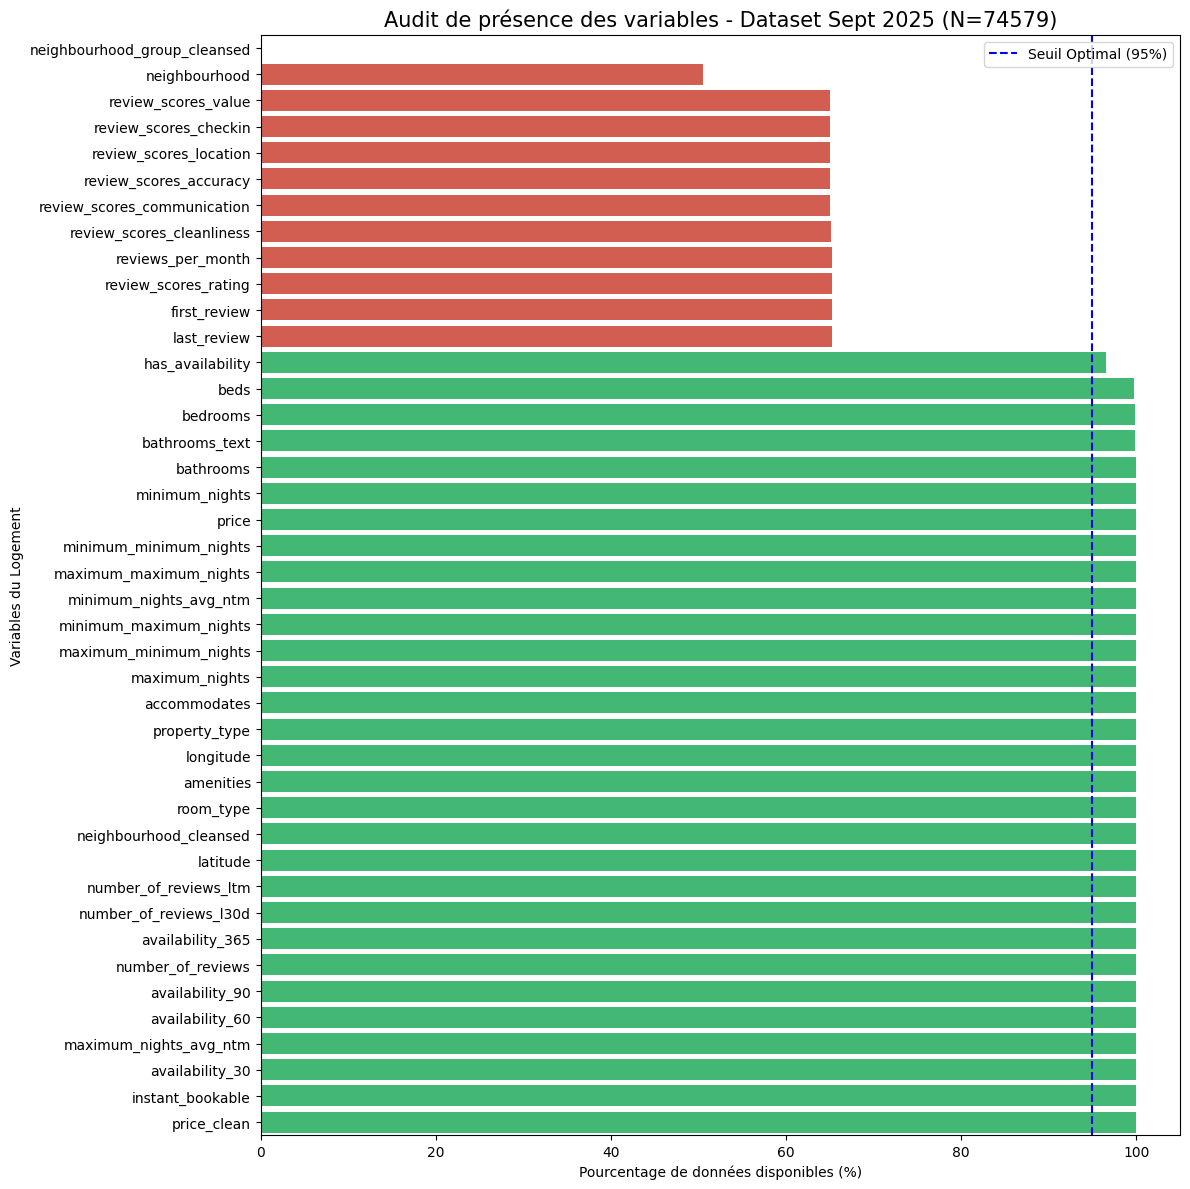


--- ⚠️ VARIABLES VIDES (0% de données) ---
['neighbourhood_group_cleansed']

--- CHECK CRITIQUE : AMENITIES ---
✅ AMENITIES : 100.00% (C'est bon !)


In [14]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

RAW_FILE_PATH = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"

# --- CRÉATION DU DOSSIER (Sécurité) ---
# On récupère le chemin du dossier (../data) et on le crée s'il n'existe pas
folder_path = os.path.dirname(RAW_FILE_PATH)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"📂 Dossier créé : {folder_path}")

if not os.path.exists(RAW_FILE_PATH):
    print(f"⚠️ ERREUR : Le fichier {RAW_FILE_PATH} est introuvable.")
    print("Assurez-vous d'avoir lancé le script de téléchargement précédent.")
else:
    # ==============================================================================
    # 2. CHARGEMENT & FILTRAGE (Scraping & Host)
    # ==============================================================================
    print(f"\n2. Chargement du fichier : {RAW_FILE_PATH}...")
    df = pd.read_csv(RAW_FILE_PATH)

    # Définition des colonnes techniques à supprimer (Scraping)
    scraping_cols = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 
        'description', 'neighborhood_overview', 'picture_url', 'calendar_updated', 
        'calendar_last_scraped', 'license'
    ]

    # Identification automatique des colonnes "Host" (Hôte)
    host_cols = [c for c in df.columns if c.startswith('host_') or c.startswith('calculated_host_')]

    # Liste totale à supprimer
    cols_to_drop = scraping_cols + host_cols

    # On ne supprime que celles qui existent vraiment dans le fichier
    existing_drops = [c for c in cols_to_drop if c in df.columns]
    df_audit = df.drop(columns=existing_drops)

    print(f"   -> {len(existing_drops)} colonnes supprimées (Liées au Host ou Scrapping).")
    print(f"   -> Reste : {df_audit.shape[1]} colonnes axées sur le LOGEMENT.")

    # ==============================================================================
    # 3. AUDIT VISUEL (Barplot)
    # ==============================================================================
    print("\n3. Génération de l'audit de complétude...")

    # Calcul du % de présence
    presence = df_audit.notnull().mean() * 100
    presence_df = presence.reset_index()
    presence_df.columns = ['Variable', 'Taux_Presence']
    presence_df = presence_df.sort_values(by='Taux_Presence', ascending=True)

    # Visualisation
    plt.figure(figsize=(12, 12))
    # Code couleur : Rouge si < 90%, Vert sinon
    colors = ['#e74c3c' if x < 90 else '#2ecc71' for x in presence_df['Taux_Presence']]

    sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)

    plt.axvline(x=95, color='blue', linestyle='--', label='Seuil Optimal (95%)')
    plt.title(f'Audit de présence des variables - Dataset Sept 2025 (N={len(df)})', fontsize=15)
    plt.xlabel('Pourcentage de données disponibles (%)')
    plt.ylabel('Variables du Logement')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Affichage des variables vides à 100% (à supprimer immédiatement)
    print("\n--- ⚠️ VARIABLES VIDES (0% de données) ---")
    empty_cols = presence_df[presence_df['Taux_Presence'] == 0]['Variable'].tolist()
    print(empty_cols if empty_cols else "Aucune variable totalement vide.")
    
    # CHECK SPECIFIQUE AMENITIES
    print("\n--- CHECK CRITIQUE : AMENITIES ---")
    amenities_score = presence_df[presence_df['Variable'] == 'amenities']['Taux_Presence'].values
    if len(amenities_score) > 0 and amenities_score[0] > 99:
         print(f"✅ AMENITIES : {amenities_score[0]:.2f}% (C'est bon !)")
    else:
         print(f"❌ AMENITIES : {amenities_score}% (Problème persistant)")

Verification of presence of amenities and prices in the dataset


--- Distribution du Prix (74579 lignes) ---
count       74579
unique       1598
top       $150.00
freq         2176
Name: price_clean, dtype: object


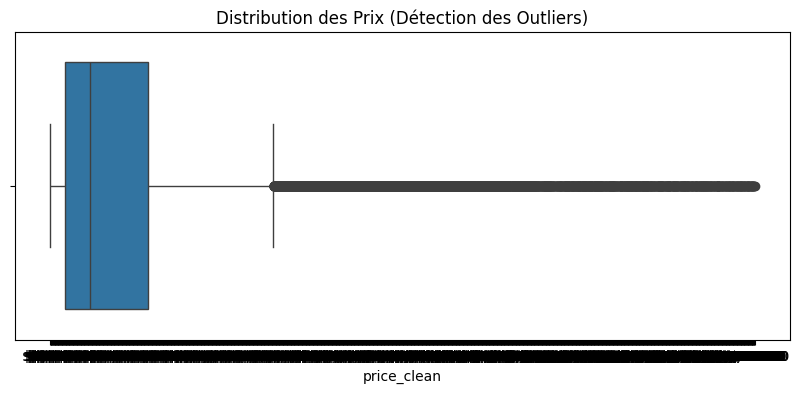


--- Structure des Amenities (Exemple Ligne 0) ---
Type : <class 'str'>
Contenu : ["Smart lock", "Smoke alarm", "Cooking basics", "Hangers", "Wifi", "Dishes and silverware", "Hair dryer", "Children\u2019s books and toys", "Kitchen",...
Parsing Test : OK (15 équipements détectés)


In [15]:
# A. Analyse du PRIX
print(f"\n--- Distribution du Prix ({len(df)} lignes) ---")
print(df['price_clean'].describe())

# Visualisation rapide des prix pour voir les outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price_clean'])
plt.title("Distribution des Prix (Détection des Outliers)")
plt.show()

# B. Analyse des AMENITIES
print("\n--- Structure des Amenities (Exemple Ligne 0) ---")
amenity_sample = df['amenities'].iloc[0]
print(f"Type : {type(amenity_sample)}")
print(f"Contenu : {str(amenity_sample)[:150]}...") # On affiche les 150 premiers caractères

# Test de parsing
import json
try:
    # On teste si c'est du JSON standard
    test_parse = json.loads(amenity_sample.replace("'", '"')) if isinstance(amenity_sample, str) else amenity_sample
    print(f"Parsing Test : OK ({len(test_parse)} équipements détectés)")
except:
    print("Parsing Test : Format complexe (nécessitera un nettoyage spécifique)")

Encoding amneties, d'abbord audit

=== AMENITIES AVEC COUNT > 1000 ===
                                                    count
Kitchen                                             69676
Wifi                                                66596
Smoke alarm                                         57304
Hot water                                           56073
Essentials                                          53450
Hair dryer                                          52177
Dishes and silverware                               51611
Bed linens                                          50821
Cooking basics                                      50625
Iron                                                48111
Refrigerator                                        47818
Hangers                                             46897
Washer                                              46746
Microwave                                           41038
TV                                                  40045
Heating                             

<Axes: title={'center': 'Top 30 Amenities à Paris'}>

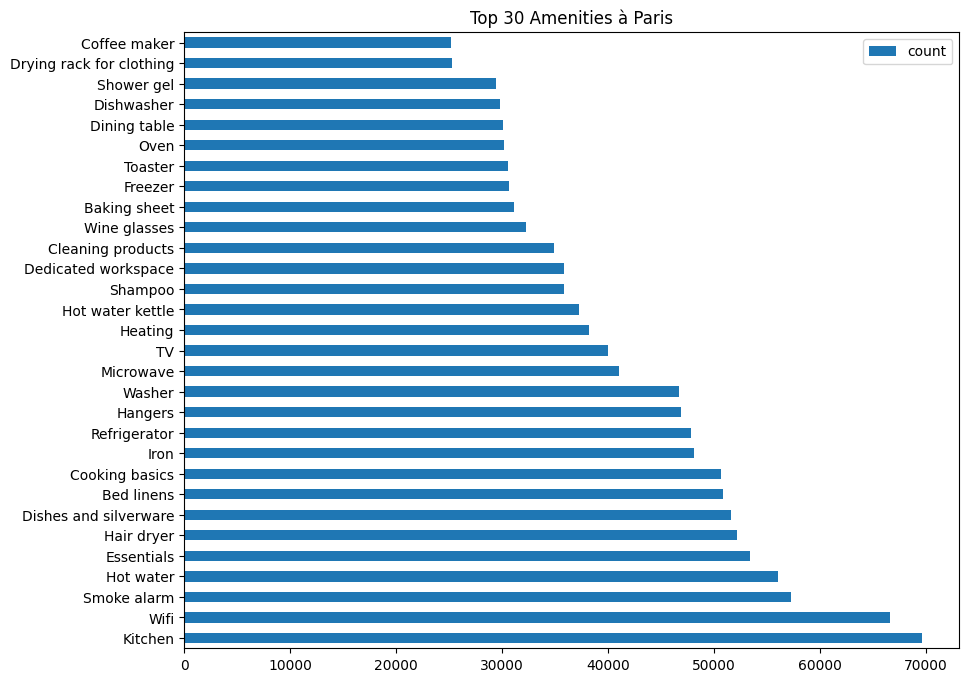

In [17]:
from collections import Counter
import json

# 1. On transforme les strings en listes réelles
def get_amenities_list(x):
    try:
        # Gère le format JSON ["Wifi", "TV"] ou le format simple
        return json.loads(x.replace("'", '"')) if isinstance(x, str) else x
    except Exception as e:
        
        return []

all_amenities = []
df['amenities'].apply(get_amenities_list).apply(all_amenities.extend)

# 2. On compte les occurrences
amenity_counts = Counter(all_amenities)
amenity_freq = pd.DataFrame.from_dict(amenity_counts, orient='index', columns=['count'])
amenity_freq = amenity_freq.sort_values(by='count', ascending=False)

# 3. Affichage des amenities avec count > 1000
print("=== AMENITIES AVEC COUNT > 1000 ===")
with pd.option_context('display.max_rows', None):
    print(amenity_freq[amenity_freq['count'] > 1000])

# Visualisation de la "longue traîne"
amenity_freq.head(30).plot(kind='barh', figsize=(10, 8), title="Top 30 Amenities à Paris")

Création df sans les colonnes inutiles pour le modèle modulable pour d'autres villes

In [21]:
import pandas as pd
import numpy as np
import re
import os

# ==============================================================================
# FONCTION UNIQUE ET DÉFINITIVE (VERSION RICHE : BEDS/BATHS/REVIEWS)
# ==============================================================================
def process_paris_from_scratch(file_path):
    print(f"🔄 Chargement depuis : {file_path}")
    
    # 1. Chargement (Optimisé RAM)
    df = pd.read_csv(file_path, compression='gzip', low_memory=False)
    print(f"   Input shape : {df.shape}")

    # 2. Nettoyage PRIX
    if 'price' in df.columns:
        df['price_clean'] = df['price'].astype(str).str.replace(r'[$,€£]', '', regex=True)
        df['price_clean'] = df['price_clean'].str.replace(',', '')
        df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')
    else:
        raise KeyError("❌ Le fichier source ne contient pas de colonne 'price' !")

    df = df.dropna(subset=['price_clean'])
    if len(df) == 0: raise ValueError("❌ ERREUR : Le nettoyage du prix a tout supprimé.")
        
    # Filtre Outliers
    q1, q99 = df['price_clean'].quantile([0.01, 0.99])
    df = df[(df['price_clean'] >= q1) & (df['price_clean'] <= q99)]
    print(f"   💰 Prix valides : {len(df)} listings")

    # 3. Géographie
    lat_center, lon_center = 48.8566, 2.3522
    df['dist_raw'] = np.sqrt((df['latitude'] - lat_center)**2 + (df['longitude'] - lon_center)**2)
    city_radius = df['dist_raw'].quantile(0.95)
    df['dist_to_center'] = np.clip(df['dist_raw'] / city_radius, 0, 1)
    
    # 4. Extraction Bathrooms (NOUVEAU : On garde l'info !)
    if 'bathrooms_text' in df.columns:
        def clean_bath(text):
            if pd.isna(text): return 1.0
            text = str(text).lower()
            if 'half' in text: return 0.5
            res = re.findall(r"(\d+(\.\d+)?)", text)
            return float(res[0][0]) if res else 1.0
        df['bathrooms_qty'] = df['bathrooms_text'].apply(clean_bath)
    else:
        # Si la colonne n'existe pas, on met une médiane par défaut
        df['bathrooms_qty'] = 1.0

    # 5. Amenities (Hybride)
    if 'amenities' in df.columns:
        df['amen_str'] = df['amenities'].astype(str).str.lower()
        
        # Power Items
        power_map = {
            'has_ac': 'air conditioning|clim',
            'has_elevator': 'elevator|lift|ascenseur',
            'has_dishwasher': 'dishwasher|lave-vaisselle',
            'has_parking': 'parking',
            'has_balcony': 'balcony|terrace|patio|balcon|terrasse',
            'has_washing_machine': 'washer|lave-linge'
        }
        for col, regex in power_map.items():
            df[col] = df['amen_str'].str.contains(regex, regex=True).astype(int)
            
        # Standing Thermique
        def get_thermal(text):
            if 'air conditioning' in text or 'clim' in text: return 2
            if 'fan' in text or 'ventilateur' in text: return 1
            return 0
        df['standing_thermal'] = df['amen_str'].apply(get_thermal)

        # Scores
        themes = {
            'score_chef_kitchen': ['stove', 'oven', 'refrigerator', 'freezer', 'wine glasses'],
            'score_coffee': ['coffee maker', 'espresso', 'nespresso'],
            'score_wellness': ['pool', 'sauna', 'jacuzzi', 'bathtub'],
            'score_work': ['wifi', 'dedicated workspace', 'monitor'],
            'score_view': ['view', 'skyline', 'waterfront'],
            'score_secure': ['lockbox', 'self check-in']
        }
        for score_name, keywords in themes.items():
            df[score_name] = df['amen_str'].apply(lambda x: sum(1 for k in keywords if k in x))

    # 6. Quartier
    if 'neighbourhood_cleansed' in df.columns:
        freq = df['neighbourhood_cleansed'].value_counts(normalize=True)
        df['neigh_popularity'] = df['neighbourhood_cleansed'].map(freq).fillna(0)

    # 7. Encodage
    if 'property_type' in df.columns:
        def group_prop(x):
            x = str(x).lower()
            if 'entire' in x or 'apt' in x: return 'entire_unit'
            if 'private' in x: return 'private_room'
            if 'hotel' in x: return 'hotel'
            return 'other'
        df['prop_group'] = df['property_type'].apply(group_prop)
        df = pd.get_dummies(df, columns=['prop_group'], prefix='pg', drop_first=False)

    if 'room_type' in df.columns:
        df = pd.get_dummies(df, columns=['room_type'], prefix='rt', drop_first=False)

    # 8. Nettoyage Final
    df['city_label'] = 'Paris'
    df['target_class'] = pd.qcut(df['price_clean'], q=4, labels=[0, 1, 2, 3]).astype(int)

    # LISTE DES COLONNES À SUPPRIMER (J'ai retiré bedrooms, beds, number_of_reviews de cette liste)
    cols_to_drop = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 
        'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_response_time', 
        'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
        'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 
        'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 
        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 
        'longitude', 'property_type', 'room_type', 'bathrooms', 'bathrooms_text', # On garde bathrooms_qty créé plus haut
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 
        'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
        'maximum_maximum_nights', 'maximum_nights_avg_ntm', 
        'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 
        'availability_90', 'availability_365', 'calendar_last_scraped', 
        'number_of_reviews_ltm', 'number_of_reviews_l30d', # On garde number_of_reviews global
        'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 
        'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
        'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
        'reviews_per_month', 'amen_str', 'dist_raw', 'pg_other', 'rt_Hotel room'
    ]
    
    # Suppression sécurisée
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
    
    # Imputation (Pour beds, bedrooms et bathrooms_qty)
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    print(f"✅ Terminé ! Shape finale : {df.shape}")
    return df


# ==============================================================================
# EXÉCUTION
# ==============================================================================
RAW_FILE_PATH = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"

df_paris_final = process_paris_from_scratch(RAW_FILE_PATH)

print("\n🚀 Colonnes disponibles :")
print(df_paris_final.columns.tolist())

# Sauvegarde de sécurité
df_paris_final.to_csv('../data/paris_dataset_final_ready.csv.gz', index=False, compression='gzip')


🔄 Chargement depuis : ../data/paris_listings_ready_2024-06-10.csv.gz
   Input shape : (74579, 76)
   💰 Prix valides : 73111 listings
✅ Terminé ! Shape finale : (73111, 30)

🚀 Colonnes disponibles :
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']


In [19]:
# Vérification
print(f"Dataset final prêt : {df_paris_final.shape}")

pd.set_option('display.max_columns', None)

print(df_paris_final.head())


Dataset final prêt : (73111, 32)
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0   1.0                     1.0                403   
3             4       2.0   1.0                    10.0                354   
4             1       1.0   1.0                     4.0                278   

   price_clean  dist_to_center  bathrooms_qty  has_ac  has_elevator  \
0        250.0        0.577017            1.0       0             0   
1         60.0        0.252107            1.5       0             0   
2         96.0        0.102716            1.0       0             0   
3        160.0        0.036952            1.0       0             0   
4         48.0        0.469133            1.0       1             1   

   has_dishwasher  has_parking  has_balcony  has_washing_machine  \
0  

A ne pas relancer, c'est pour justifier la supression de certaines colonnes dans le dataset final (meme si la plupart des variables non utilises ne sont pas detaille ici)

=== 1. AUDIT TECHNIQUE (Valeurs manquantes & Types) ===
✅ Aucun NaN détecté. Dataset 100% rempli.

Types de colonnes :
int64      16
bool        8
float64     7
str         1
Name: count, dtype: int64

=== 2. AUDIT DE L'ÉQUILIBRE (Target) ===
target_class
0    0.261438
1    0.238664
2    0.250291
3    0.249607
Name: proportion, dtype: float64
✅ Classes bien équilibrées (Effet Quartiles).

=== 3. AUDIT DU SIGNAL (Corrélations) ===
Top 10 Corrélations Positives (Ce qui fait monter le prix) :
price_clean         1.000000
target_class        0.681494
bedrooms            0.465915
accommodates        0.465111
bathrooms_qty       0.409981
beds                0.310000
has_dishwasher      0.186338
has_ac              0.175888
score_wellness      0.171071
standing_thermal    0.155358
Name: price_clean, dtype: float64

Top 5 Corrélations Négatives (Ce qui fait baisser le prix) :
score_view                0.032500
minimum_nights_avg_ntm   -0.064034
number_of_reviews        -0.080754
neigh_populari

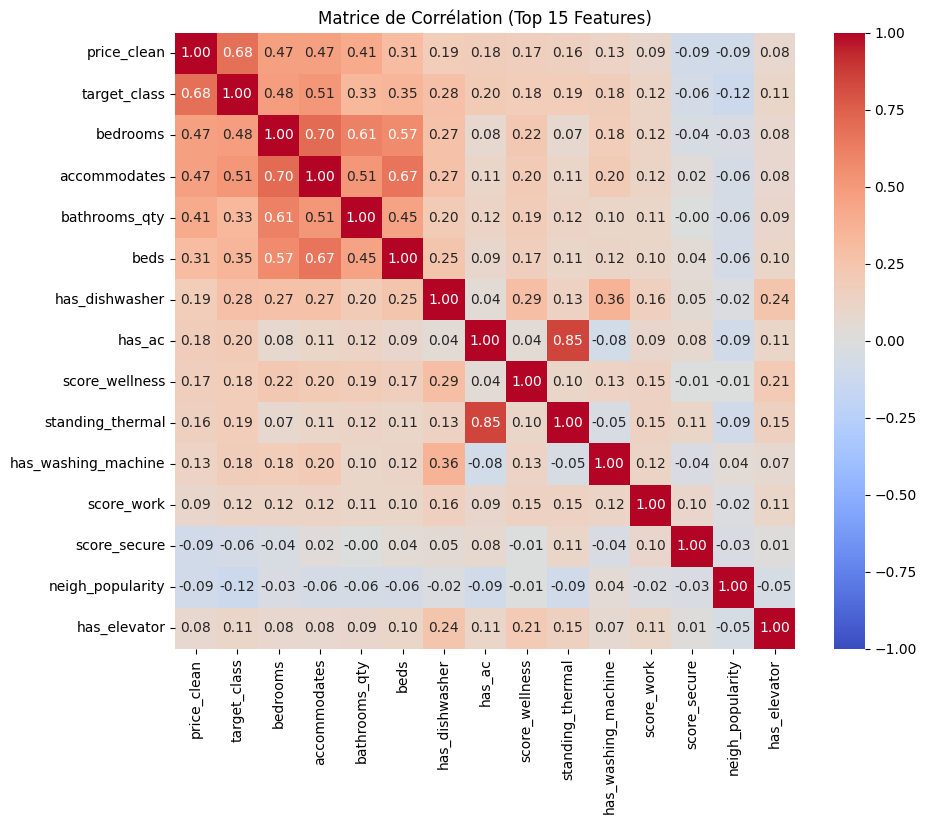


=== 4. DÉTECTION DES 'VARIANCES NULLES' (Colonnes inutiles) ===
⚠️ Colonnes quasi-constantes (>99%) détectées : [('pg_other', np.float64(0.9968267428977856)), ('rt_Hotel room', np.float64(0.9924361587175664)), ('rt_Shared room', np.float64(0.9976610906703506)), ('city_label', np.float64(1.0))]
Conseil : Vous pouvez les supprimer, elles n'apportent presque aucune info.


In [ ]:
df = df_paris_final

print("=== 1. AUDIT TECHNIQUE (Valeurs manquantes & Types) ===")
# Vérification des NaNs (tout doit être à 0)
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("✅ Aucun NaN détecté. Dataset 100% rempli.")
else:
    print("⚠️ ATTENTION : Il reste des NaNs !")
    print(null_counts[null_counts > 0])

# Vérification des types (Tout doit être int ou float, sauf city_label)
print("\nTypes de colonnes :")
print(df.dtypes.value_counts())

print("\n=== 2. AUDIT DE L'ÉQUILIBRE (Target) ===")
# La cible doit être à peu près équilibrée (25% partout)
target_dist = df['target_class'].value_counts(normalize=True).sort_index()
print(target_dist)
if target_dist.max() < 0.30 and target_dist.min() > 0.20:
    print("✅ Classes bien équilibrées (Effet Quartiles).")
else:
    print("⚠️ Classes déséquilibrées (Attention aux prix ex-aequo).")

print("\n=== 3. AUDIT DU SIGNAL (Corrélations) ===")
# Quelles sont les variables qui expliquent le mieux le prix ?
# On calcule la corrélation de tout avec 'price_clean'
corr_matrix = df.select_dtypes(include=[np.number]).corr()
price_corr = corr_matrix['price_clean'].sort_values(ascending=False)

print("Top 10 Corrélations Positives (Ce qui fait monter le prix) :")
print(price_corr.head(10))

print("\nTop 5 Corrélations Négatives (Ce qui fait baisser le prix) :")
print(price_corr.tail(5))

# Visualisation Heatmap simplifiée
plt.figure(figsize=(10, 8))
# On prend les 15 variables les plus corrélées (pos ou neg)
top_cols = price_corr.abs().sort_values(ascending=False).head(15).index
sns.heatmap(df[top_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matrice de Corrélation (Top 15 Features)")
plt.show()

print("\n=== 4. DÉTECTION DES 'VARIANCES NULLES' (Colonnes inutiles) ===")
# Si une colonne a 99.9% de la même valeur (ex: tout le monde a le Wifi), elle ne sert à rien
useless_cols = []
for col in df.columns:
    if df[col].dtype != 'object':
        most_common_val_pct = df[col].value_counts(normalize=True).iloc[0]
        if most_common_val_pct > 0.99:
            useless_cols.append((col, most_common_val_pct))

if useless_cols:
    print(f"⚠️ Colonnes quasi-constantes (>99%) détectées : {useless_cols}")
    print("Conseil : Vous pouvez les supprimer, elles n'apportent presque aucune info.")
else:
    print("✅ Toutes les colonnes ont une variance suffisante.")